# Hierarchical Ar(1) on a Grid Test with STAN

In this notebook, we will test the compositional score matching on a hierarchical problem defined on a grid.
- The observations are on grid with `n_grid` x `n_grid` points.
- The global parameters are the same for all grid points with hyper-priors:
$$ \alpha \sim \mathcal{N}((0, 1) \quad
  \mu_\beta \sim \mathcal{N}(0, 1) \quad
  \log\text{std}_\beta \sim \mathcal{N}(-1, 1);$$

- The local parameters are different for each grid point
$$ \beta_{i,j} \sim \mathcal{N}(\mu_\beta, \text{std}_\beta^2)$$

-  In each grid point, we have a time series of `T` observations. For the time beeing, we fix $\sigma=1$.
$$ y_{i,j} \sim \mathcal{N}(\alpha + \beta_{i,j}y_{i,j-1}, \sigma^2)$$
- We observe $T=10$ time points for each grid point. We can also amortize over the time dimension.

In [ ]:
import os

import numpy as np

os.environ['KERAS_BACKEND'] = 'torch'
from bayesflow import diagnostics

from problems.ar1_grid import Prior, Simulator, get_stan_posterior, plot_shrinkage, visualize_simulation_output

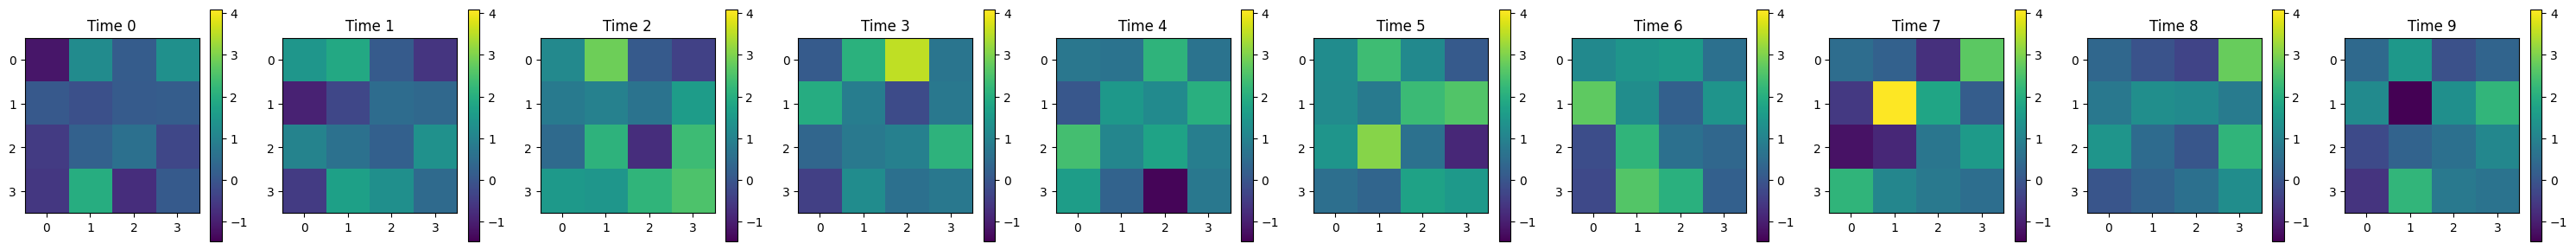

{'alpha': array([[0.80970322]]), 'beta_mu': array([[0.2780358]]), 'log_beta_std': array([[-1.47452411]]), 'beta': array([[ 0.20566722,  0.39869363,  0.24848941,  0.41658118,  0.30394558,
         0.4910031 ,  0.05698994,  0.30700704, -0.1295961 ,  0.05714257,
        -0.03188832,  0.24176441,  0.20095106,  0.13818321, -0.02779433,
        -0.10374169]])}


In [9]:
T = 10
N = 16
data_samples = 100

prior = Prior(n_time_points=T, N=N)
simulator = Simulator(n_time_points=T)

global_param_names = [r'$\alpha$', r'$\beta$', r'$\log \text{std}\,\beta$']
local_param_names = [r'$\beta_{' + str(i) + '}$' for i in range(N)]

params_test = prior.sample_full(1)
test = simulator(params_test)['observable'][0]
visualize_simulation_output(test)

print(params_test)

In [ ]:
np.random.seed(42)

global_posteriors = []
local_posteriors = []

true_global = []
true_local = []

for i in range(data_samples):
    print(i)
    param_sample = prior.sample_full(1)
    true_global.append([param_sample['alpha'][0, 0], param_sample['beta_mu'][0, 0], param_sample['log_beta_std'][0, 0]])
    true_local.append(param_sample['beta'].flatten())
    sim_test = simulator(param_sample)['observable'][0]

    global_posterior, local_posterior = get_stan_posterior(sim_test, sigma_noise=simulator.sigma_noise)
    global_posteriors.append(global_posterior)
    local_posteriors.append(local_posterior)

# make numpy arrays
global_posterior = np.stack(global_posteriors, axis=0)
local_posterior = np.stack(local_posteriors, axis=0).transpose(0, 2, 1)

true_global = np.stack(true_global, axis=0)
true_local = np.stack(true_local, axis=0)

In [10]:
np.save('problems/ar1/global_posterior.npy', global_posterior)
np.save('problems/ar1/local_posterior.npy', local_posterior)
np.save('problems/ar1/true_global.npy', true_global)
np.save('problems/ar1/true_local.npy', true_local)

# Plotting

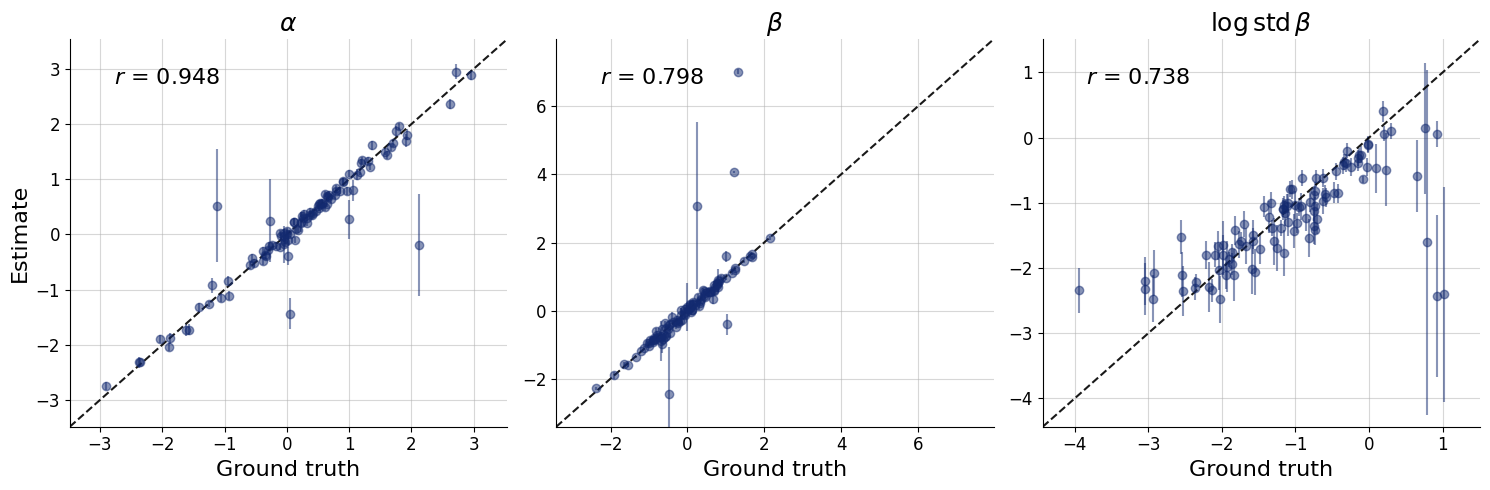

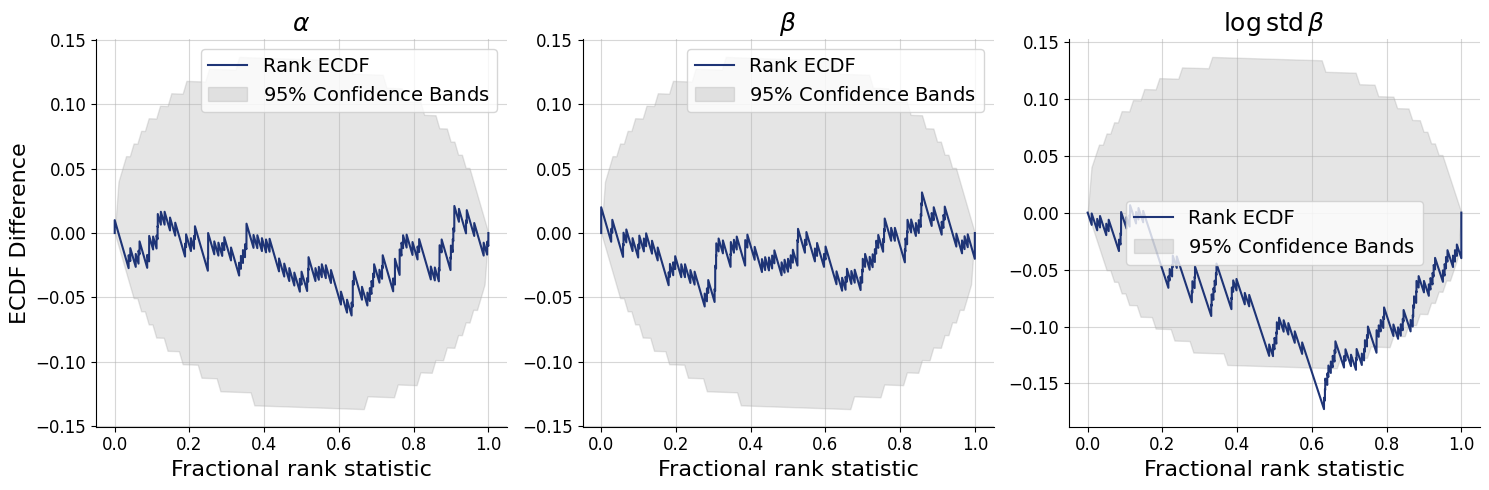

In [11]:
diagnostics.recovery(global_posterior, true_global, variable_names=global_param_names)
diagnostics.calibration_ecdf(global_posterior, true_global, difference=True, variable_names=global_param_names);

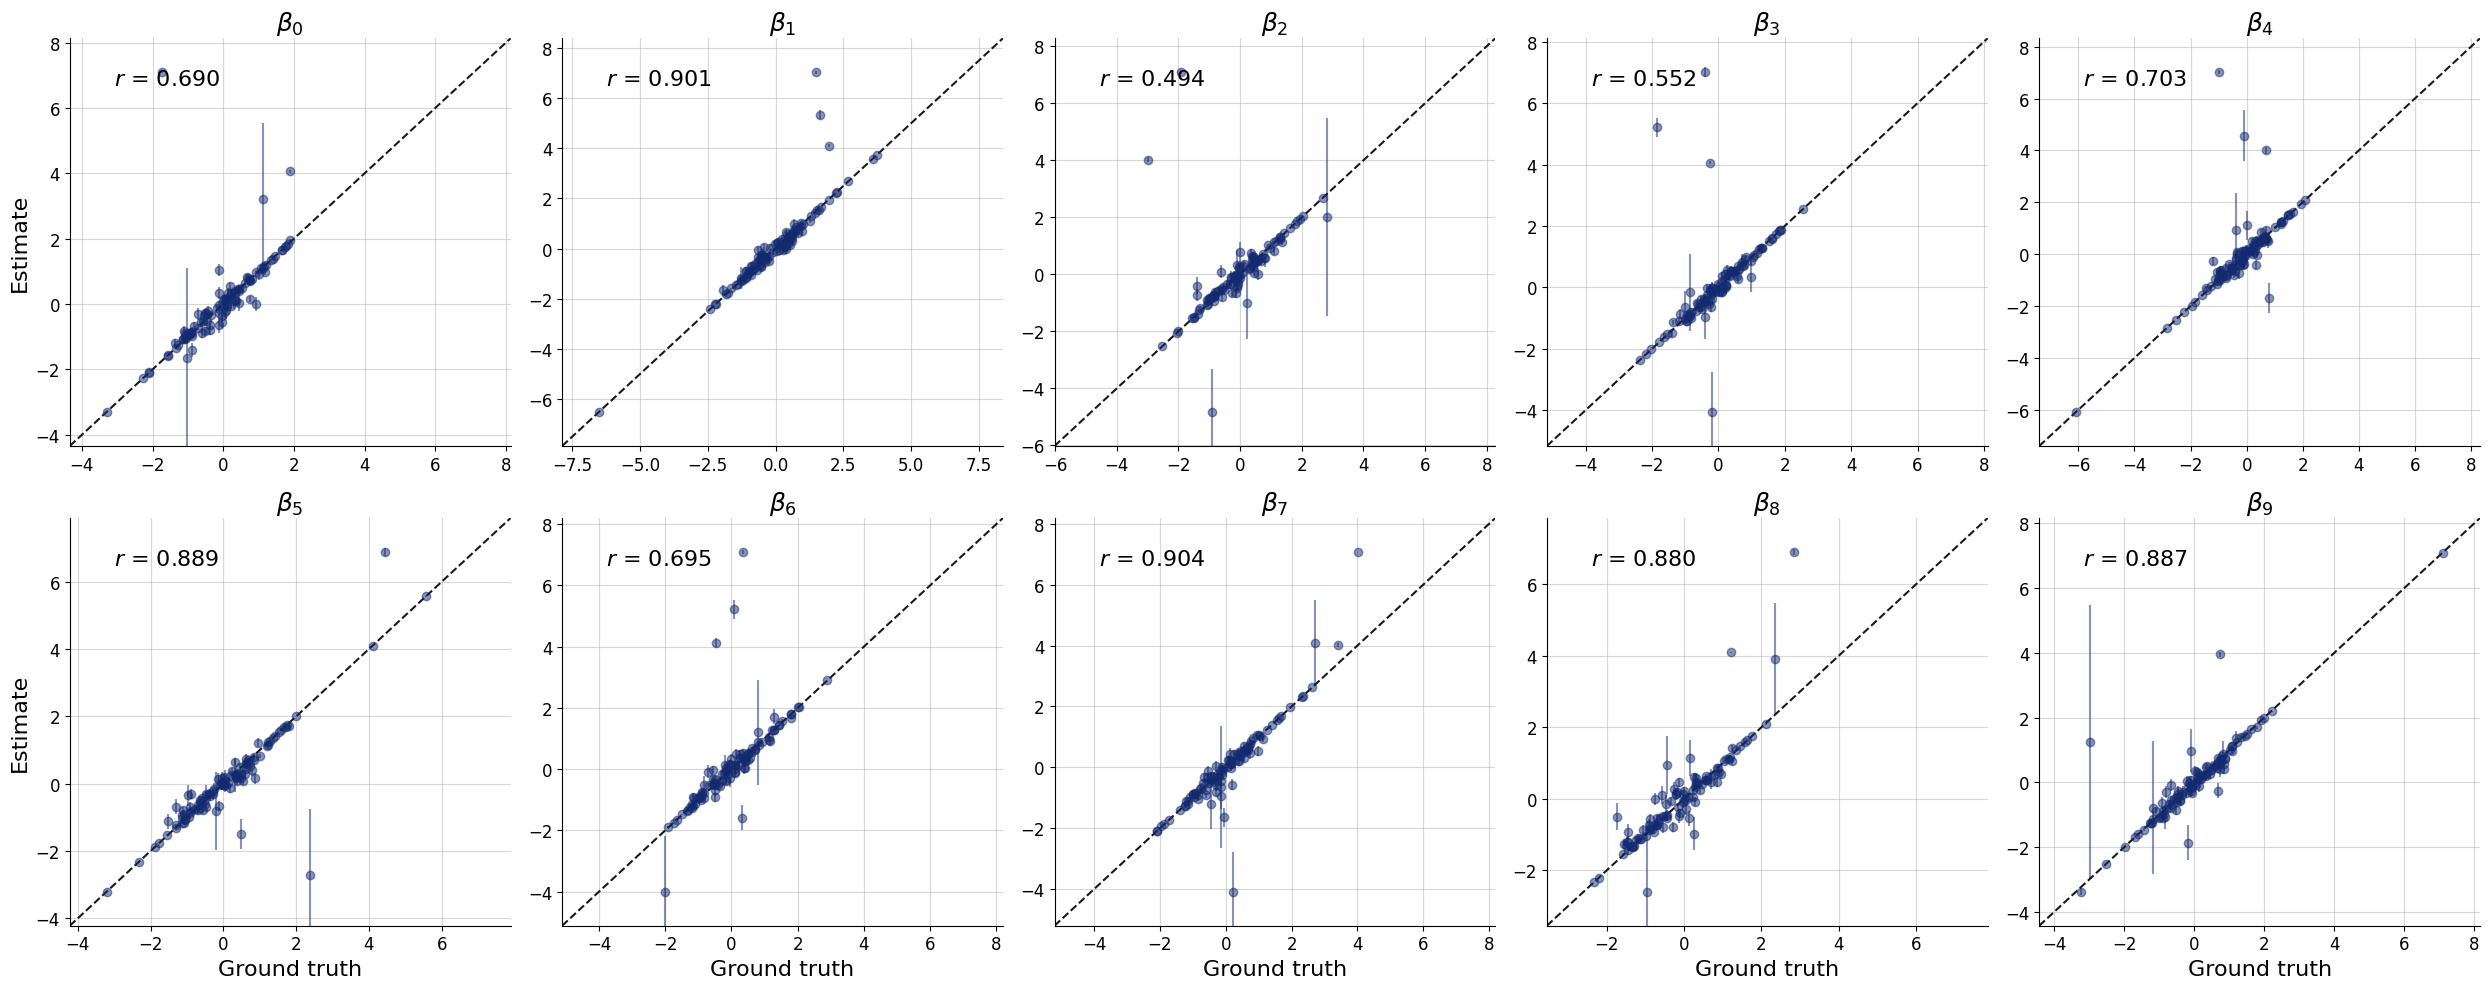

In [12]:
diagnostics.recovery(local_posterior[:, :, :10], true_local[:, :10], variable_names=local_param_names[:10]);

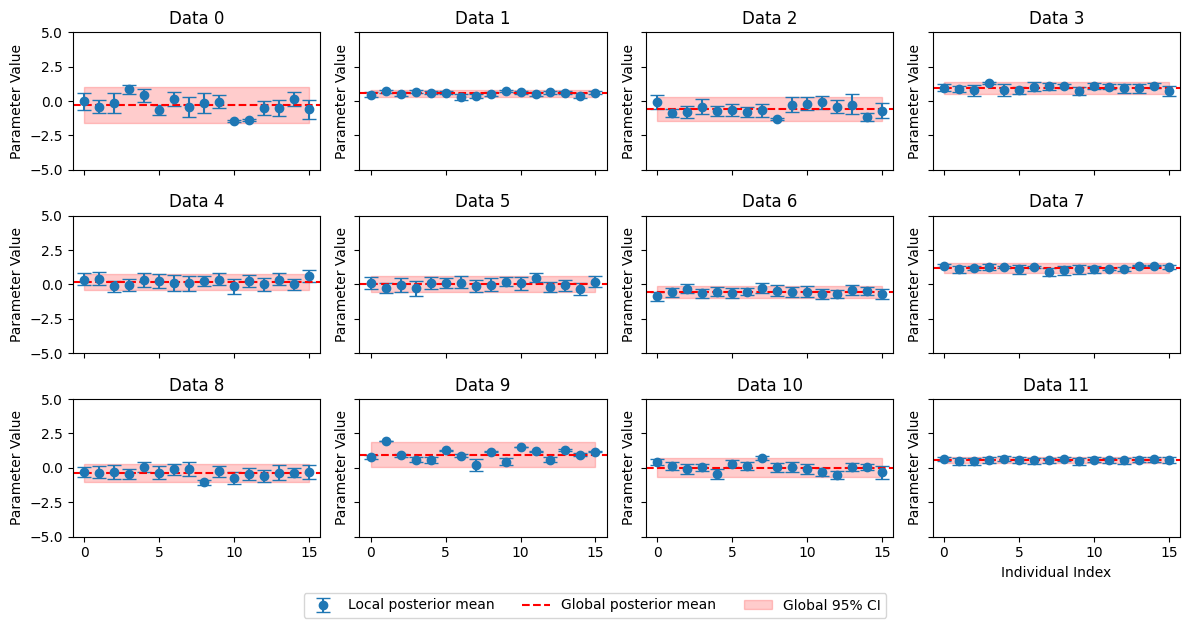

In [13]:
plot_shrinkage(global_posterior[:12], local_posterior[:12, :, :, np.newaxis], min_max=(-5, 5))